## Initial Setups

In [3]:
!pip install -qU langchain\
    langchain-community\
    langchain-together\
    langchain-core\
    faiss-cpu\
    faiss-gpu\
    langgraph\
    sentence-transformers\
    gradio

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.4/341.4 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.6 MB/s eta 0:00:00


In [4]:
import os
from dotenv import load_dotenv
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_together import ChatTogether
from langchain_community.vectorstores import FAISS
from langchain.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Literal
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from IPython.core.display import Markdown
from langchain_core.messages import HumanMessage, AIMessage
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate


In [5]:
#os.environ["TAVILY_API_KEY"] = "your_KEY"
os.environ["TOGETHER_API_KEY"] = "your_KEY"

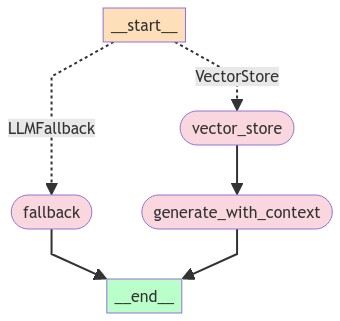

## Loading Data

In [6]:
import requests
from bs4 import BeautifulSoup

def extract_chapter_links(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    links = [a['href'] for a in soup.find_all('a', href=True) if a['href'].endswith('.pdf')]
    return links

url = 'https://stanford.edu/~jurafsky/slp3/'
chapter_links = extract_chapter_links(url)
for link in chapter_links:
    print(link)

ed3bookfeb3_2024.pdf
2.pdf
slides/2_TextProc_2023.pdf
3.pdf
4.pdf
slides/4_NB_2024.pdf
5.pdf
slides/5_LR_Apr_7_2021.pdf
6.pdf
slides/vectorsemantics2024.pdf
7.pdf
slides/7_NN_Apr_28_2021.pdf
8.pdf
slides/8_POSNER_intro_May_6_2021.pdf
9.pdf
10.pdf
11.pdf
13.pdf
14.pdf
15.pdf
slides/24_Dialogue_May_6_2021.pdf
16.pdf
17.pdf
18.pdf
19.pdf
20.pdf
21.pdf
22.pdf
23.pdf
A.pdf
B.pdf
C.pdf
D.pdf
E.pdf
F.pdf
G.pdf
H.pdf


In [ ]:
!pip install --upgrade --quiet pypdf
from langchain_community.document_loaders import PyPDFLoader
pdfs = []
for link in chapter_links:
    full_link = link if link.startswith('http') else 'https://web.stanford.edu/~jurafsky/slp3/' + link
    loader = PyPDFLoader(full_link)
    docs = loader.load()
    pdfs.append(docs)

In [8]:
print(pdfs)

[[Document(metadata={'source': 'https://web.stanford.edu/~jurafsky/slp3/ed3bookfeb3_2024.pdf', 'page': 0}, page_content='Speech and Language Processing\nAn Introduction to Natural Language Processing,\nComputational Linguistics, and Speech Recognition\nThird Edition draft\nDaniel Jurafsky\nStanford University\nJames H. Martin\nUniversity of Colorado at Boulder\nCopyright ©2023. All rights reserved.\nDraft of February 3, 2024. Comments and typos welcome!'), Document(metadata={'source': 'https://web.stanford.edu/~jurafsky/slp3/ed3bookfeb3_2024.pdf', 'page': 1}, page_content='Summary of Contents\nI Fundamental Algorithms for NLP 1\n1 Introduction. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 3\n2 Regular Expressions, Text Normalization, Edit Distance . . . . . . . . . 4\n3 N-gram Language Models . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 32\n4 Naive Bayes, Text Classiﬁcation, and Sentiment . . . . . . . 

## Chunking, Vector Store and Retriever

In [9]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
chunks = []
for document in pdfs:
  chunks.extend(text_splitter.split_documents(document))

In [10]:
print(len(chunks))

5731


In [11]:
embedding_function = HuggingFaceEmbeddings(show_progress=True, multi_process=True)
vector_store = FAISS.from_documents(documents=chunks, embedding=embedding_function)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(
/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/sett

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [12]:
retriever.get_relevant_documents('What is Markov chain?')

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


[Document(metadata={'source': 'https://web.stanford.edu/~jurafsky/slp3/ed3bookfeb3_2024.pdf', 'page': 176}, page_content='states , each of which can take on values from some set. These sets can be words, or\ntags, or symbols representing anything, for example the weather. A Markov chain\nmakes a very strong assumption that if we want to predict the future in the sequence,\nall that matters is the current state. All the states before the current state have no im-\npact on the future except via the current state. It’s as if to predict tomorrow’s weather\nyou could examine today’s weather but you weren’t allowed to look at yesterday’s\nweather.\nWARM3HOT1COLD2.8.6.1.1.3.6.1.1.3\ncharminguniformlyare.1.4.5.5.5.2.6.2\n(a) (b)\nFigure 8.8 A Markov chain for weather (a) and one for words (b), showing states and\ntransitions. A start distribution πis required; setting π= [0.1,0.7,0.2]for (a) would mean a\nprobability 0.7 of starting in state 2 (cold), probability 0.1 of starting in state 1 (ho

In [13]:
retriever.get_relevant_documents('What is Binary search tree (BST)?')

[Document(metadata={'source': 'https://web.stanford.edu/~jurafsky/slp3/18.pdf', 'page': 14}, page_content='the search space as directed graphs and employ methods drawn from graph theory\nto search the space for optimal solutions. More formally, given a sentence Swe’re\nlooking for the best dependency tree in Gs, the space of all possible trees for that\nsentence, that maximizes some score.\nˆT(S) =argmax\nt∈GSScore (t,S)'),
 Document(metadata={'source': 'https://web.stanford.edu/~jurafsky/slp3/ed3bookfeb3_2024.pdf', 'page': 412}, page_content='the search space as directed graphs and employ methods drawn from graph theory\nto search the space for optimal solutions. More formally, given a sentence Swe’re\nlooking for the best dependency tree in Gs, the space of all possible trees for that\nsentence, that maximizes some score.\nˆT(S) =argmax\nt∈GSScore (t,S)'),
 Document(metadata={'source': 'https://web.stanford.edu/~jurafsky/slp3/ed3bookfeb3_2024.pdf', 'page': 414}, page_content='The ful

In [14]:
retriever.get_relevant_documents('Who is the president of Bolivia?')

[Document(metadata={'source': 'https://web.stanford.edu/~jurafsky/slp3/ed3bookfeb3_2024.pdf', 'page': 57}, page_content='COCA is a balanced corpus, meaning that it has roughly equal numbers of words\nfrom different genres: web, newspapers, spoken conversation transcripts, ﬁction,\nand so on, drawn from the period 1990-2019, and has the context of each n-gram as\nwell as labels for genre and provenance.\nSome example 4-grams from the Google Web corpus:\n4-gram Count\nserve as the incoming 92\nserve as the incubator 99\nserve as the independent 794\nserve as the index 223\nserve as the indication 72\nserve as the indicator 120\nserve as the indicators 45\nEfﬁciency considerations are important when building language models that use\nsuch large sets of n-grams. Rather than store each word as a string, it is generally\nrepresented in memory as a 64-bit hash number, with the words themselves stored\non disk. Probabilities are generally quantized using only 4-8 bits (instead of 8-byte\nﬂoats

## Chains

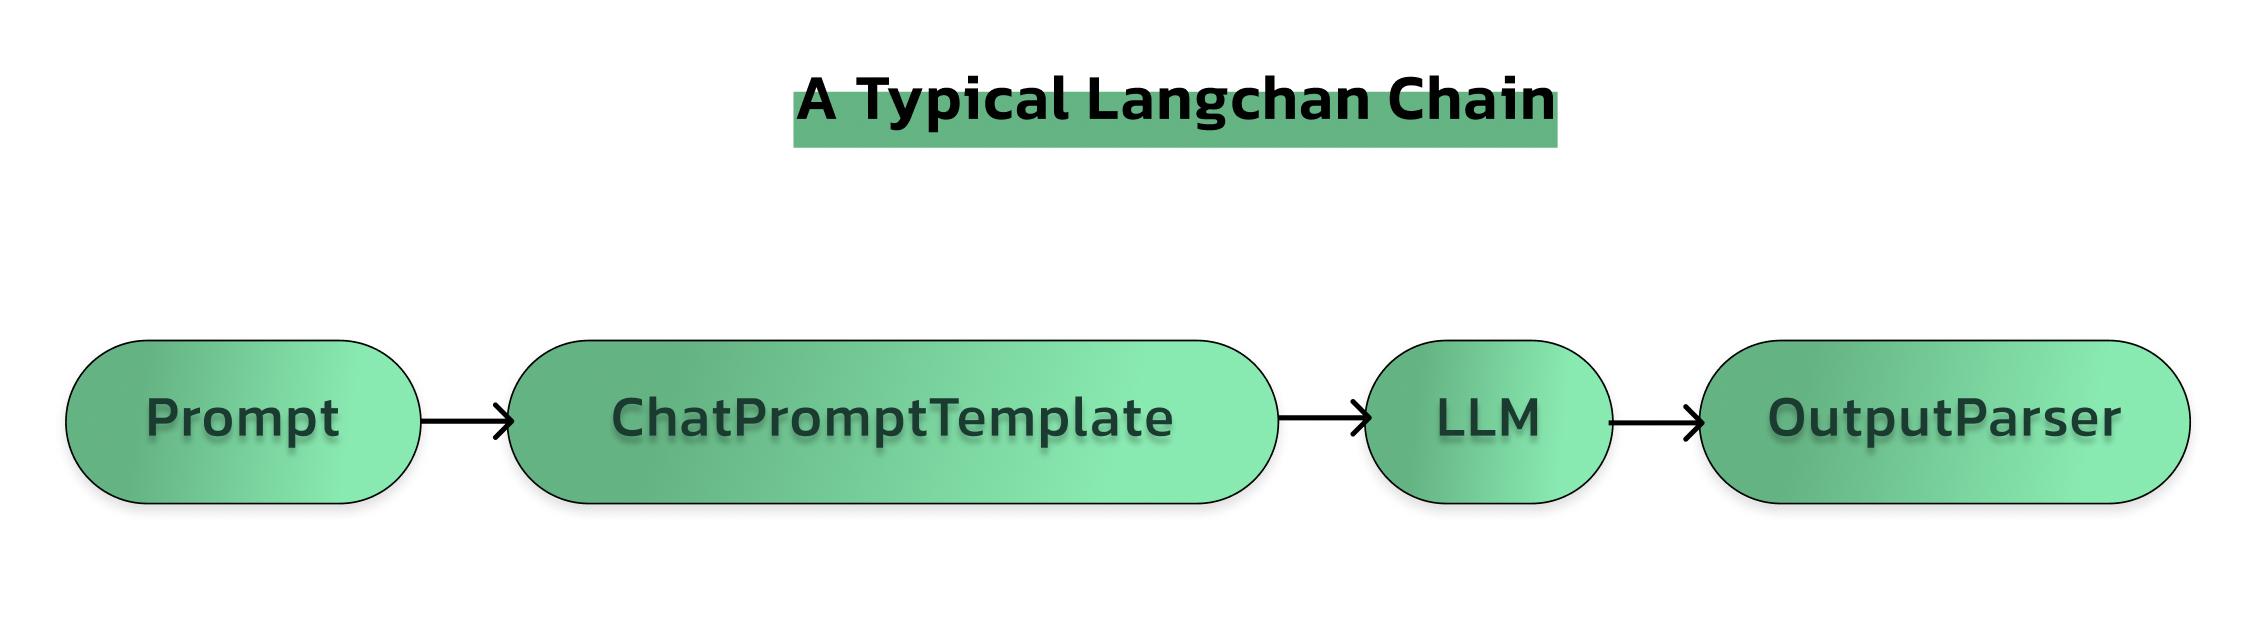

### Prompt

In [15]:

llm = ChatTogether(
    model="meta-llama/Llama-3-70b-chat-hf",
    temperature= 0
    )


In [16]:
from pprint import pprint

raw_prompt = "Hi, I'm learning langchain to use it with LLMs and make awesome stuff!"
llm.invoke(raw_prompt).content

"That's awesome! Langchain is a powerful tool for building applications with large language models (LLMs). It provides a simple and flexible way to interact with LLMs, making it easier to build a wide range of language-based applications.\n\nWhat kind of projects are you planning to build with Langchain and LLMs? Are you interested in natural language processing, text generation, conversational AI, or something else?\n\nAlso, which LLMs are you planning to use with Langchain? Some popular options include OpenAI's models, Hugging Face's Transformers, and Google's BERT-based models.\n\nFeel free to share your ideas, and I'll be happy to help you get started or provide guidance as you build your projects!"

In [17]:
prompt_template = "Hi, I'm learning {tool} to use it with LLMs and make awesome stuff!"

prompt_chat_template = ChatPromptTemplate.from_template(
    template=prompt_template,
)

prompt_chat_template.invoke({
    "tool":"llama_index"
})


ChatPromptValue(messages=[HumanMessage(content="Hi, I'm learning llama_index to use it with LLMs and make awesome stuff!")])

In [18]:
prompt = prompt_chat_template.invoke({
    "tool":"llama_index"
})
llm.invoke(prompt).content

"That's great to hear! LlamaIndex is an amazing tool for building applications with Large Language Models (LLMs). It provides a simple and efficient way to index and query large language models, making it easier to integrate them into your projects.\n\nWhat kind of awesome stuff are you planning to build with LlamaIndex and LLMs? Are you looking to create a chatbot, a language-based game, or something entirely new?\n\nIf you have any questions or need help getting started with LlamaIndex, feel free to ask. I'm here to assist you!"

In [19]:
chain = prompt_chat_template | llm

chain.invoke(
    {
    "tool":"llama_index"
  }
).content

"That's great to hear! LlamaIndex is an amazing tool for building applications with Large Language Models (LLMs). It provides a simple and efficient way to index and query large language models, making it easier to integrate them into your projects.\n\nWhat kind of awesome stuff are you planning to build with LlamaIndex and LLMs? Are you looking to create a chatbot, a language-based game, or something entirely new?\n\nIf you have any questions or need help getting started with LlamaIndex, feel free to ask. I'm here to assist you!"

In [20]:
router_prompt_template = (
    "You are an expert in routing user queries to the most relevant category based on the content of the query.\n"
    "Your expertise allows you to choose between 'Natural Language Processing (NLP)' and 'Computer Science (CS)' or no category at all.\n"
    "If the given query is specifically about topics within Natural Language Processing, choose VectorStore.\n"
    "If the query pertains to topics in Computer Science that are not related to Natural Language Processing, choose SearchEngine.\n"
    "If the query is not related to these specified fields, return 'None'.\n"
    "Remember, give me only the name of the category you chose or 'None' if none applies. Provide only this information and nothing more.\n"
    "{output_instructions}"
    "query: {query}"
)



prompt = ChatPromptTemplate.from_template(
    template=router_prompt_template,
)


### Pydantic Parser

In [21]:
from typing import Literal

class ChosenTool(BaseModel):
    tool_name: Literal['None', "VectorStore", "SearchEngine"] = Field(description="the tool that was chosen by LLM in question routing stage")


question_router_parser = PydanticOutputParser(pydantic_object=ChosenTool)

question_router_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"tool_name": {"title": "Tool Name", "description": "the tool that was chosen by LLM in question routing stage", "enum": ["None", "VectorStore", "SearchEngine"], "type": "string"}}, "required": ["tool_name"]}\n```'

In [22]:
chain_router = prompt | llm | question_router_parser

res = chain_router.invoke({"query": "Do you know about Tehran?",
                                   "output_instructions": question_router_parser.get_format_instructions()
 })
res

ChosenTool(tool_name='None')

In [23]:
res = chain_router.invoke({"query": "Do you know about Binery Search Tree?",
                                   "output_instructions": question_router_parser.get_format_instructions()
 })
res

ChosenTool(tool_name='SearchEngine')

In [24]:
res = chain_router.invoke({"query": "Do you know about HMM's?",
                                   "output_instructions": question_router_parser.get_format_instructions()
 })
res

ChosenTool(tool_name='VectorStore')

In [25]:
test_chain = prompt | llm

test_chain.invoke({
    "query": "What is NLP?",
    "output_instructions": question_router_parser.get_format_instructions()
})

AIMessage(content='{"tool_name": "VectorStore"}', response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 326, 'total_tokens': 335}, 'model_name': 'meta-llama/Llama-3-70b-chat-hf', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-07c0b906-6631-4db2-b5b9-33838108cbef-0', usage_metadata={'input_tokens': 326, 'output_tokens': 9, 'total_tokens': 335})

### Generate with Context Chain

In [26]:
generate_with_context_template = (
    "Please respond to the query below based solely on the context provided. If the context given is irrelevant or does not directly relate to the query, refrain from using your own knowledge to provide an answer.\n\n"
    "context: {context}\n\n"
    "query: {query}"
)


generate_with_context_prompt = ChatPromptTemplate.from_template(generate_with_context_template)

generate_with_context_chain = generate_with_context_prompt | llm | StrOutputParser()

query = "What is HMM?"
context = retriever.get_relevant_documents(query)
response = generate_with_context_chain.invoke({"query": query, "context": context})

Markdown(response)

Based on the provided context, a Hidden Markov Model (HMM) is a probabilistic model that allows us to talk about both observed events (like words that we see in the input) and hidden events (like part-of-speech tags) that we think of as causal factors in our probabilistic model. An HMM is specified by the following components: 

1. Q = q1, q2, ..., qN: a set of N states
2. A = a11, ..., ai j, ..., aNN: a transition probability matrix A, each ai j representing the probability of moving from state i to state j
3. B = bi(ot): a sequence of observation likelihoods, also called emission probabilities, each expressing the probability of an observation ot being generated from a state qi
4. π = π1, π2, ..., πN: an initial probability distribution over states. πi is the probability that the system is in state qi at the start.

In [27]:
fallback_prompt = ChatPromptTemplate.from_template(
    (
        "You are a knowledgeable assistant specializing in Computer Science, created by the NLP Staff Course at the University of Tehran.\n"
        "Do not respond to queries that are not related to Computer Science.\n"
        "If a query is not related to Computer Science, please acknowledge your limitations.\n"
        "Provide concise responses to queries that strictly pertain to Computer Science.\n\n"
        "Current conversations:\n\n{chat_history}\n\n"
        "human: {query}"
    )
)

fallback_chain = (
    {
        "chat_history": lambda x: "\n".join(
            [
                (
                    f"human: {msg.content}"
                    if isinstance(msg, HumanMessage)
                    else f"AI: {msg.content}"
                )
                for msg in x["chat_history"]
            ]
        ),
        "query": itemgetter("query") ,
    }
    | fallback_prompt
    | llm
    | StrOutputParser()
)

fallback_chain.invoke(
    {
        "query": "Hello",
        "chat_history": [],
    }
)

"Hello! I'm happy to assist you with any Computer Science-related questions or topics. What would you like to discuss?"

In [28]:
!pip install tavily-python

In [30]:
from langchain_community.tools.tavily_search import TavilySearchResults

os.environ["TAVILY_API_KEY"] = "your_KEY"
tool = TavilySearchResults()
tool.invoke({"query": "What is red-black tree?"})

[{'url': 'https://www.geeksforgeeks.org/introduction-to-red-black-tree/',
  'content': 'What is a Red-Black Tree? A Red-Black Tree is a self-balancing binary search tree where each node has an additional attribute: a color, which can be either red or black.The primary objective of these trees is to maintain balance during insertions and deletions, ensuring efficient data retrieval and manipulation.'},
 {'url': 'https://en.wikipedia.org/wiki/Red–black_tree',
  'content': 'A red-black tree is a special type of binary search tree, used in computer science to organize pieces of comparable data, such as text fragments or numbers (as e.g. the numbers in figures 1 and 2).'},
 {'url': 'https://brilliant.org/wiki/red-black-tree/',
  'content': 'A red-black tree is a type of binary search tree. It is self balancing like the AVL tree, though it uses different properties to maintain the invariant of being balanced. Balanced binary search trees are much more efficient at search than unbalanced bina

In [31]:
from langchain_core.documents import Document
tool = TavilySearchResults()

def create_docs(results: list):
  documents = []
  for result in results[:5]:
    documents.append(Document(
          page_content=result['content'],
          metadata={"source": result['url']}
      )
    )
  return documents


search_engine_chain = tool | create_docs

prompt = "What is red-black tree?"
documents = search_engine_chain.invoke({"query": prompt})

print(documents)

[Document(metadata={'source': 'https://www.geeksforgeeks.org/introduction-to-red-black-tree/'}, page_content='What is a Red-Black Tree? A Red-Black Tree is a self-balancing binary search tree where each node has an additional attribute: a color, which can be either red or black.The primary objective of these trees is to maintain balance during insertions and deletions, ensuring efficient data retrieval and manipulation.'), Document(metadata={'source': 'https://en.wikipedia.org/wiki/Red–black_tree'}, page_content='A red-black tree is a special type of binary search tree, used in computer science to organize pieces of comparable data, such as text fragments or numbers (as e.g. the numbers in figures 1 and 2).'), Document(metadata={'source': 'https://www.programiz.com/dsa/red-black-tree'}, page_content='Red-Black tree is a self-balancing binary search tree in which each node contains an extra bit for denoting the color of the node, either red or black. A red-black tree satisfies the follo

# Agent Workflow

In [32]:
from typing import TypedDict, Annotated
from langchain_core.documents import Document
from langchain_core.messages.base import BaseMessage
import operator




class AgentSate(TypedDict):
    """The dictionary keeps track of the data required by the various nodes in the graph"""

    query: str
    chat_history:list[BaseMessage]
    generation: str
    documents: list[Document]


def retrieve_node(state: dict):
    """
    Retrieve relevent documents from the vectorstore

    query: str

    return list[Document]
    """
    query = state["query"]
    documents = retriever.invoke(input=query)
    return {"documents": documents}


def fallback_node(state: dict):
    """
    Fallback to this node when there is no tool call
    """
    query = state["query"]
    chat_history = state["chat_history"]
    generation = fallback_chain.invoke({"query": query, "chat_history": chat_history})
    return {"generation": generation}



def generate_with_context_node(state: dict):
    query = state["query"]
    documents = state["documents"]

    generation = generate_with_context_chain.invoke({"query": query, "context": documents})
    return {"generation": generation}


def search_engine_node(state: dict):
    query = state["query"]
    documents = search_engine_chain.invoke({"query": query})
    return {"documents": documents}



def question_router_node(state: dict):
    query = state["query"]
    try:
        response = chain_router.invoke({"query": query,
                                   "output_instructions": question_router_parser.get_format_instructions()
        })
    except Exception:
        print("Exception in getting response")
        return "LLMFallback"
    try:
      chosen_tool = response.tool_name.lower()
    except Exception:
        return "LLMFallback"

    if chosen_tool == 'none':
        print("---No tool called---")
        return "LLMFallback"


    if chosen_tool == "vectorstore":
        print("---Routing to VectorStore---")
        return "VectorStore"

    if chosen_tool == "searchengine":
        print("---Routing to SearchEngine---")
        return "SearchEngine"
    return "LLMFallback"

In [33]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentSate)

workflow.add_node("vector_store", retrieve_node)
workflow.add_node("fallback", fallback_node)
workflow.add_node("generate_with_context", generate_with_context_node)
workflow.add_node("search_engine", search_engine_node)

workflow.set_conditional_entry_point(
    question_router_node,
    {
        "LLMFallback": "fallback",
        "VectorStore": "vector_store",
        "SearchEngine": "search_engine",
    },
)

workflow.add_edge("vector_store", "generate_with_context")

workflow.add_edge("search_engine", "generate_with_context")

workflow.add_edge("generate_with_context", END)

workflow.add_edge("fallback", END)


In [34]:
app = workflow.compile(debug=False)
plot = app.get_graph().draw_mermaid_png()

with open("plot.png", "wb") as fp:
    fp.write(plot)

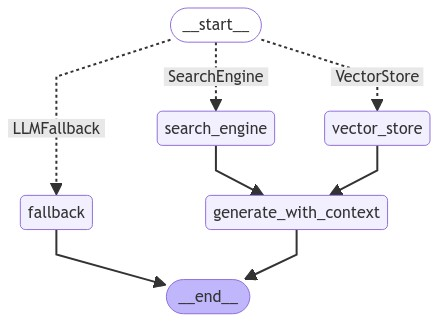

In [35]:
from io import BytesIO
from PIL import Image
from IPython.display import display

img = Image.open(BytesIO(plot))
display(img)

In [36]:
response = app.invoke({"query": "who is the president of Iran?", "chat_history": []})
Markdown(response["generation"])

---No tool called---


I'm happy to help! However, I must acknowledge that my expertise is limited to Computer Science, and I'm not knowledgeable about political figures or current events. I can only provide information and answer questions related to Computer Science. If you have a question about algorithms, data structures, programming languages, or any other CS-related topic, I'd be happy to help!

In [37]:
response = app.invoke({"query": "What is NLP?", "chat_history": []})
Markdown(response["generation"])

---Routing to VectorStore---


Based on the provided context, NLP is not explicitly defined. However, it can be inferred that NLP stands for Natural Language Processing, as it is mentioned in the context of various applications such as machine translation, information retrieval, question answering, dialogue systems, and speech recognition.

In [39]:
response = app.invoke({"query": "What is Binary Search Tree?", "chat_history": []})
Markdown(response["generation"])

---Routing to SearchEngine---


A Binary Search Tree is a data structure used in computer science for organizing and storing data in a sorted manner. Each node in a Binary Search Tree has at most two children, a left child and a right child, with the left child containing values less than the parent node and the right child containing values greater than the parent node.

In [40]:
import gradio as gr
from uuid import uuid4

history = {}
session_id = str(uuid4())

def chat(query):

    # Initialize the chat history for the current session
    if session_id not in history:
        history[session_id] = []

    chat_history = history[session_id]

    # Invoke the app with the current query and chat history
    result = app.invoke({"query": query, "chat_history": chat_history})

    # Separate the response from the retrieved documents
    response = result["generation"]
    documents = result["documents"]

    # Add the current exchange to the chat history
    chat_history.extend([HumanMessage(content=query), AIMessage(content=response)])

    if not documents:
        return response, documents

    documents = [
        f"{doc.page_content}\nsource: {doc.metadata['source']}" for doc in documents
    ]

    return response, "\n\n".join(documents)

# Create the Gradio interface
demo = gr.Interface(
    fn=chat,
    inputs=gr.Textbox(label="Question"),
    outputs=[gr.Textbox(label="Response"), gr.Textbox(label="Retrieved Documents")],
    title="RAG Chatbot",
    description="Ask a health-related query and the chatbot will generate a response using Retrieval Augmented Generation.",
)

if __name__ == "__main__":
    demo.launch(share=True, inline=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://15504f813543a38b05.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
